<a href="https://colab.research.google.com/github/akitim/SkillFactory_projects/blob/main/Project_2_EDA_Timofey_Akimkin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Загрузка библиотек

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')
from itertools import combinations
from scipy.stats import ttest_ind
 
%matplotlib inline

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок
 
import sys
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
sys.path.clear
sys.path.append('/content/gdrive/MyDrive/SkillFactory')

/usr/lib/python3.7/threading.py:874: ResourceWarning: unclosed file <_io.FileIO name=65 mode='wb' closefd=True>
  del self._target, self._args, self._kwargs
/usr/lib/python3.7/threading.py:874: ResourceWarning: unclosed file <_io.FileIO name=66 mode='rb' closefd=True>
  del self._target, self._args, self._kwargs


Mounted at /content/gdrive


#Считывание датафрейма из файла

In [91]:
students = pd.read_csv('/content/gdrive/MyDrive/SkillFactory/stud_math.csv')
display(students.sample(10))

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
250,GP,M,18,U,GT3,T,3.0,2.0,services,NaN,course,mother,2.0,1.0,1.0,no,no,no,no,yes,-3.0,NaN,yes,no,4.0,4.0,5.0,5.0,0.0,40.0
89,GP,M,16,U,LE3,A,4.0,4.0,teacher,health,reputation,mother,1.0,2.0,0.0,no,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,NaN,5.0,18.0,35.0
265,GP,M,18,R,LE3,NaN,3.0,4.0,NaN,other,reputation,mother,2.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,2.0,5.0,1.0,NaN,85.0
146,GP,F,15,U,GT3,T,3.0,2.0,health,services,home,father,1.0,2.0,3.0,no,NaN,no,no,yes,-6.0,yes,yes,no,3.0,3.0,2.0,3.0,0.0,0.0
159,GP,M,16,NaN,GT3,T,3.0,NaN,other,services,course,father,1.0,2.0,1.0,no,yes,yes,no,yes,-6.0,yes,yes,yes,4.0,5.0,5.0,5.0,4.0,60.0
127,GP,F,19,U,GT3,T,0.0,1.0,at_home,other,course,other,1.0,2.0,3.0,no,NaN,no,no,no,-6.0,no,no,no,3.0,4.0,2.0,5.0,2.0,45.0
244,GP,F,18,U,GT3,T,2.0,1.0,other,other,course,other,2.0,3.0,0.0,no,yes,yes,no,no,-9.0,yes,yes,yes,4.0,4.0,4.0,3.0,0.0,NaN
23,GP,M,16,U,LE3,T,2.0,2.0,other,other,reputation,mother,2.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,yes,no,5.0,4.0,4.0,5.0,0.0,60.0
139,GP,F,15,U,GT3,NaN,4.0,4.0,teacher,teacher,course,mother,2.0,1.0,0.0,no,no,no,yes,yes,-3.0,yes,yes,NaN,4.0,3.0,2.0,5.0,0.0,75.0
346,GP,M,18,R,GT3,T,4.0,3.0,teacher,services,course,mother,1.0,3.0,0.0,no,no,no,no,yes,-9.0,yes,yes,yes,5.0,3.0,2.0,4.0,9.0,80.0


#Пользовательские функции

In [92]:
def hasletornum(s):
    ls = [ch for ch in s]
    return any(list(map(lambda x: x.isalnum(), ls)))


#Предобработка столбцов

In [93]:
#Приведем названия столбцов к однообразному виду
students.columns = map(lambda s: s.replace(', ', '_').lower(),
                            students.columns)
print(students.columns)

Index(['school', 'sex', 'age', 'address', 'famsize', 'pstatus', 'medu', 'fedu',
       'mjob', 'fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime_granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')


Столбец ***age***.

In [94]:
#проверяем, нет ли нечисловых значений в столюце
students.age.value_counts(dropna=False)

16    104
17     98
18     82
15     82
19     24
20      3
22      1
21      1
Name: age, dtype: int64

Нечисловые данные отсутствуют.

Столбец ***medu***.

In [95]:
display(pd.DataFrame(students.loc[:,'medu'].value_counts(dropna=False)))
# есть 3 значения NaN

#присвоим им значение None
students.loc[students.loc[:, 'medu'].isna(), 'medu'] = None

,medu
4.0,131
2.0,102
3.0,97
1.0,59
0.0,3
NaN,3


Столбец ***fedu.***

In [96]:
display(pd.DataFrame(students.loc[:, 'fedu'].value_counts(dropna=False)))
# Есть 24 значения NaN и одно значение >4 (40);
# вполне вероятно, это значение неправильно введенное значение 4
# Заменим это значение на 4:
students.loc[students.loc[:, 'fedu'] == 40.0, 'fedu'].value = 4

,fedu
2.0,106
3.0,96
4.0,88
1.0,78
NaN,24
0.0,2
40.0,1


In [97]:
print('\nОбщая характеристика датасета:')
students.info();

print('\nСтатистическая характеристика датасета:')
students.describe()


Общая характеристика датасета:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              395 non-null    object 
 1   sex                 395 non-null    object 
 2   age                 395 non-null    int64  
 3   address             378 non-null    object 
 4   famsize             368 non-null    object 
 5   pstatus             350 non-null    object 
 6   medu                392 non-null    float64
 7   fedu                371 non-null    float64
 8   mjob                376 non-null    object 
 9   fjob                359 non-null    object 
 10  reason              378 non-null    object 
 11  guardian            364 non-null    object 
 12  traveltime          367 non-null    float64
 13  studytime           388 non-null    float64
 14  failures            373 non-null    float64
 15  schoolsup           386 n

,age,medu,fedu,traveltime,studytime,failures,studytime_granular,famrel,freetime,goout,health,absences,score
count,395.000000,392.000000,371.000000,367.000000,388.000000,373.000000,388.000000,368.000000,384.000000,387.000000,380.000000,383.000000,389.000000
mean,16.696203,2.750000,2.614555,1.438692,2.038660,0.337802,-6.115979,3.937500,3.231771,3.105943,3.531579,7.279373,52.262211
std,1.276043,1.098127,2.228732,0.694181,0.842078,0.743135,2.526235,0.927277,0.993940,1.115896,1.396019,23.465197,22.919022
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-12.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,-6.000000,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,-6.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,-3.000000,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,40.000000,4.000000,4.000000,3.000000,-3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


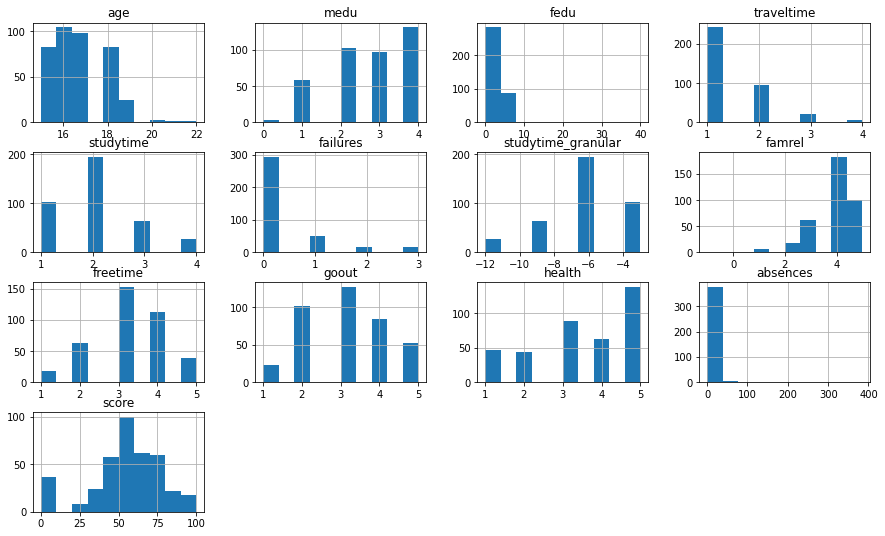

In [98]:
# display(students.loc[:, students.loc[4, :].apply(type) != str])
students.hist(figsize =(15,9));